# 低ランク近似、蒸留、そして画像圧縮について

## 1. 低ランク近似とは
低ランク近似とは、行列をより小さな行列の積で近似する手法である。  
多くの場合、行列の全ての情報が必要とされるわけではなく、情報の重要な部分を抽出し、簡略化することが可能である。この簡略化により、計算コストを削減し、メモリ使用量を最適化することができる。

例えば、以下のような行列 \( X \) を考える：
$$
\[
X =
$\begin{bmatrix}
3.97 & 3.29 & -1.72 \\
0.90 & 0.75 & -0.36 \\
2.21 & 1.83 & -0.95
\end{bmatrix}
\]
$$
この行列は以下のように2つの小さな行列 \( A \) と \( B \) の積で近似することができる：
$$
\[
X \approx A \cdot B
\]
$$
このような手法は、大規模なデータセットやモデルを効率化するために有用である。

---

## 2. 特異値分解 (SVD) とは
特異値分解 (Singular Value Decomposition; SVD) は、低ランク近似を実現するための基盤的な手法である。行列 \( X \) を以下の形に分解する：
$$
\[
X = U \cdot \Sigma \cdot V^T
\]
$$
ここで、$
- \( U \): 行列の行の情報を含む直交行列。
- \( \Sigma \): 特異値と呼ばれる値を対角成分に持つ対角行列。
- \( V^T \): 行列の列の情報を含む直交行列。
$
特異値分解を用いることで、特異値 \( \Sigma \) の大きい部分のみを利用することで行列を低ランク近似できる。例えば、上位 \( r \) 個の特異値を用いて、以下の形で行列を近似する：
$$
\[
X \approx U_{:, :r} \cdot \Sigma_{:r, :r} \cdot V_{:, :r}^T
\]
$$
この近似は、元の行列の情報の主要部分を保持しつつ、計算量を削減するために使用される。

---

## 3. 蒸留 (Knowledge Distillation) とは
蒸留 (Knowledge Distillation) は、大規模で高性能なモデル (教師モデル) の知識を、小規模で軽量なモデル (生徒モデル) に移植する手法である。この手法は、モデルのサイズを縮小しながらも、高い性能を維持するために開発された。

### 蒸留の基本的な流れ
1. 教師モデルを訓練し、または事前訓練された教師モデルを用意する。
2. 教師モデルの出力を模倣するように生徒モデルを訓練する。

具体的には、教師モデルの出力する確率分布 (ソフトラベル) を用いて、生徒モデルが教師モデルと同様の出力を得られるようにする。このとき、教師モデルが提供する「暗黙知」を活用することで、生徒モデルは単純なラベル付きデータよりも豊かな学習を行う。

---

## 4. 交差エントロピー損失とは
交差エントロピー損失は、分類問題において広く使用される損失関数である。2つの確率分布 \( p \) と \( q \) の類似度を計測するものであり、以下の式で定義される：
$$
\[
L = - \sum_{i} p_i \log q_i
\]
$$
ここで、\( p \) は正解ラベルの確率分布、\( q \) はモデルの予測する確率分布である。

### 蒸留における交差エントロピー損失
蒸留では、以下の2つの損失を組み合わせる：
1. 通常の交差エントロピー損失 (正解ラベルに基づく損失)
2. ソフトラベル間の交差エントロピー損失 (教師モデルと生徒モデルの出力分布間の損失)

これにより、生徒モデルは教師モデルの知識を学習しつつ、正解ラベルに対しても精度を高めることができる。

---

## 5. 低ランク近似を用いた画像圧縮の例
以下のコードは、低ランク近似を実際に画像圧縮に適用し、その効果を確認するものである。また、メモリ削減率や計算時間についても測定を行う。

```python
# 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize
import time

# 画像の読み込みと前処理
url = 'https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png'
image = io.imread(url)
image = resize(image, (256, 256), anti_aliasing=True)
gray_image = color.rgb2gray(image)

# 特異値分解
U, S, Vt = np.linalg.svd(gray_image, full_matrices=False)

# 再構成とメモリ・時間測定
def measure_compression(k):
    start_time = time.time()
    S_k = np.zeros_like(S)
    S_k[:k] = S[:k]
    compressed_image = np.dot(U[:, :k] * S_k[:k], Vt[:k, :])
    end_time = time.time()
    
    original_memory = U.size + S.size + Vt.size
    compressed_memory = U[:, :k].size + k + Vt[:k, :].size
    
    return compressed_image, original_memory, compressed_memory, end_time - start_time

# 特異値の数を変えて実験
k_values = [5, 20, 50, 100, 256]
results = []

for k in k_values:
    compressed_image, original_memory, compressed_memory, elapsed_time = measure_compression(k)
    results.append((k, original_memory, compressed_memory, elapsed_time))

# 結果表示
import pandas as pd
df = pd.DataFrame(results, columns=["k", "Original Memory", "Compressed Memory", "Time (s)"])
df["Memory Reduction (%)"] = ((df["Original Memory"] - df["Compressed Memory"]) / df["Original Memory"]) * 100

import ace_tools as tools; tools.display_dataframe_to_user(name="Low-Rank Approximation Results", dataframe=df)

# 再構成画像の表示
fig, axes = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    compressed_image, _, _, _ = measure_compression(k)
    axes[i].imshow(compressed_image, cmap='gray')
    axes[i].set_title(f'k = {k}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
```

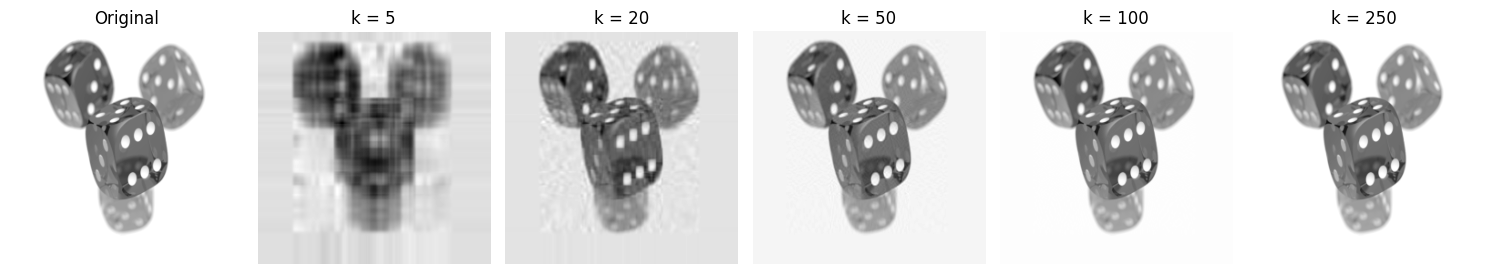

In [ ]:
# 必要なライブラリのインストールとインポート
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize

# 画像の読み込みと前処理
url = 'https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png'
image = io.imread(url)
image = resize(image, (256, 256), anti_aliasing=True)  # サイズを256x256にリサイズ
# RGBA -> RGB に変換 (アルファチャンネルの削除)
if image.shape[2] == 4:  # チャンネル数が4の場合
    image = color.rgba2rgb(image)

# グレースケール化
gray_image = color.rgb2gray(image)

# 特異値分解 (SVD)
U, S, Vt = np.linalg.svd(gray_image, full_matrices=False)

# 再構成関数
def reconstruct_image(k):
    """特異値の上位k個を使って画像を再構成する"""
    S_k = np.zeros_like(S)
    S_k[:k] = S[:k]  # 上位k個の特異値を保持
    return np.dot(U[:, :k] * S_k[:k], Vt[:k, :])

# 圧縮画像の表示
k_values = [5, 20, 50, 100, 250]  # 使用する特異値の数
fig, axes = plt.subplots(1, len(k_values) + 1, figsize=(15, 5))

# 元画像
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# 再構成画像
for i, k in enumerate(k_values):
    compressed_image = reconstruct_image(k)
    axes[i + 1].imshow(compressed_image, cmap='gray')
    axes[i + 1].set_title(f'k = {k}')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize
import time

# 画像の読み込みと前処理
url = 'https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png'
image = io.imread(url)
image = resize(image, (256, 256), anti_aliasing=True)  # サイズを256x256にリサイズ
# RGBA -> RGB に変換 (アルファチャンネルの削除)
if image.shape[2] == 4:  # チャンネル数が4の場合
    image = color.rgba2rgb(image)

# グレースケール化
gray_image = color.rgb2gray(image)

# 特異値分解 (SVD)
U, S, Vt = np.linalg.svd(gray_image, full_matrices=False)

# 再構成とメモリ・時間測定
def measure_compression(k):
    start_time = time.time()  # 時間測定開始
    S_k = np.zeros_like(S)
    S_k[:k] = S[:k]  # 上位k個の特異値を保持
    compressed_image = np.dot(U[:, :k] * S_k[:k], Vt[:k, :])
    end_time = time.time()  # 時間測定終了

    # メモリ消費量の計算
    original_memory = U.size + S.size + Vt.size  # 元のメモリ (全行列を保持)
    compressed_memory = U[:, :k].size + k + Vt[:k, :].size  # 圧縮後のメモリ (部分行列と特異値)

    return compressed_image, original_memory, compressed_memory, end_time - start_time

# 特異値の数 (k) を変えて測定
k_values = [5, 20, 50, 100, 256]
results = []

for k in k_values:
    compressed_image, original_memory, compressed_memory, elapsed_time = measure_compression(k)
    results.append((k, original_memory, compressed_memory, elapsed_time))

# 結果の表示
import pandas as pd
df = pd.DataFrame(results, columns=["k", "Original Memory", "Compressed Memory", "Time (s)"])
df["Memory Reduction (%)"] = ((df["Original Memory"] - df["Compressed Memory"]) / df["Original Memory"]) * 100

print(df)

     k  Original Memory  Compressed Memory  Time (s)  Memory Reduction (%)
0    5           131328               2565  0.000251             98.046875
1   20           131328              10260  0.000237             92.187500
2   50           131328              25650  0.000386             80.468750
3  100           131328              51300  0.000603             60.937500
4  256           131328             131328  0.001426              0.000000



--- 使用する特異値の数 k = 5 ---


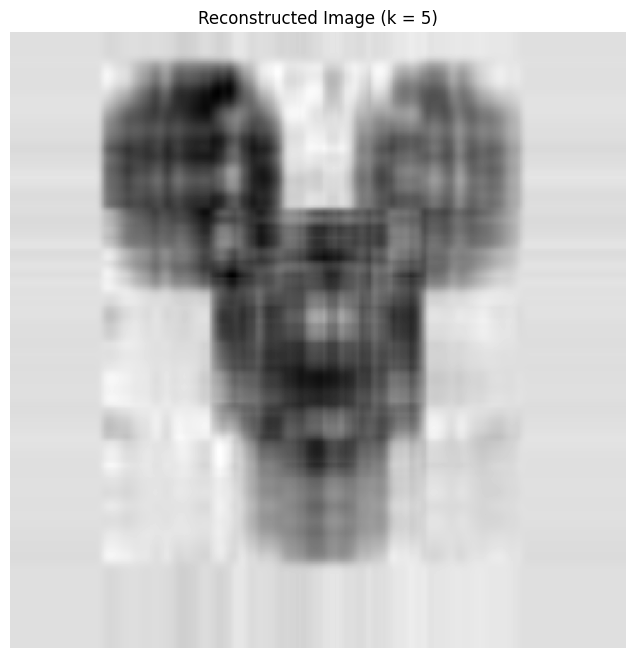

U_k shape: (256, 5)
Σ_k shape: (5, 5)
V_k shape: (5, 256)
Approximation Formula: U_k * Σ_k * V_k^T

--- 使用する特異値の数 k = 20 ---


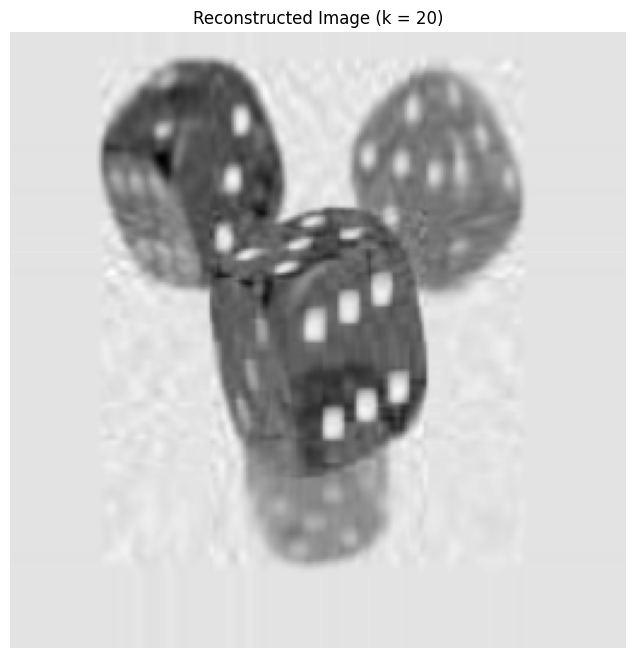

U_k shape: (256, 20)
Σ_k shape: (20, 20)
V_k shape: (20, 256)
Approximation Formula: U_k * Σ_k * V_k^T

--- 使用する特異値の数 k = 50 ---


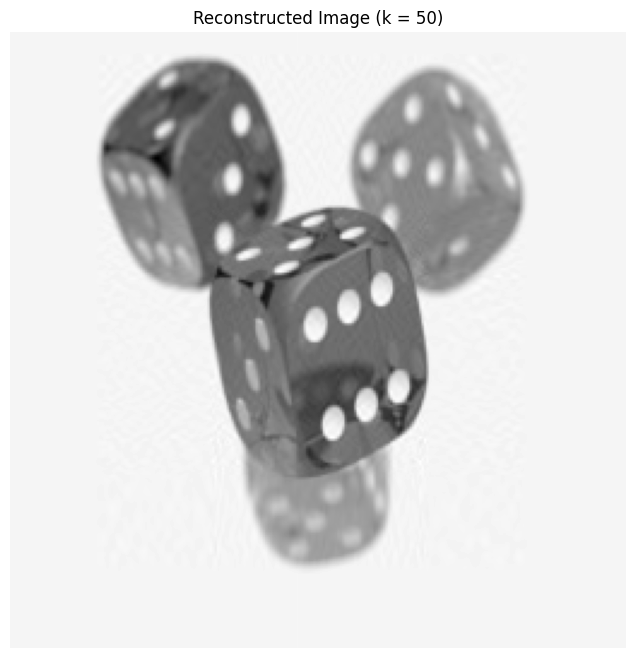

U_k shape: (256, 50)
Σ_k shape: (50, 50)
V_k shape: (50, 256)
Approximation Formula: U_k * Σ_k * V_k^T

--- 使用する特異値の数 k = 100 ---


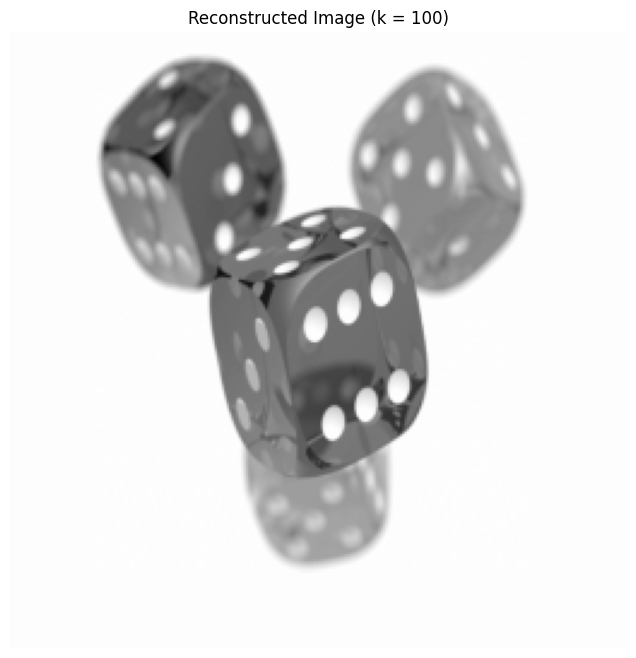

U_k shape: (256, 100)
Σ_k shape: (100, 100)
V_k shape: (100, 256)
Approximation Formula: U_k * Σ_k * V_k^T

--- 使用する特異値の数 k = 256 ---


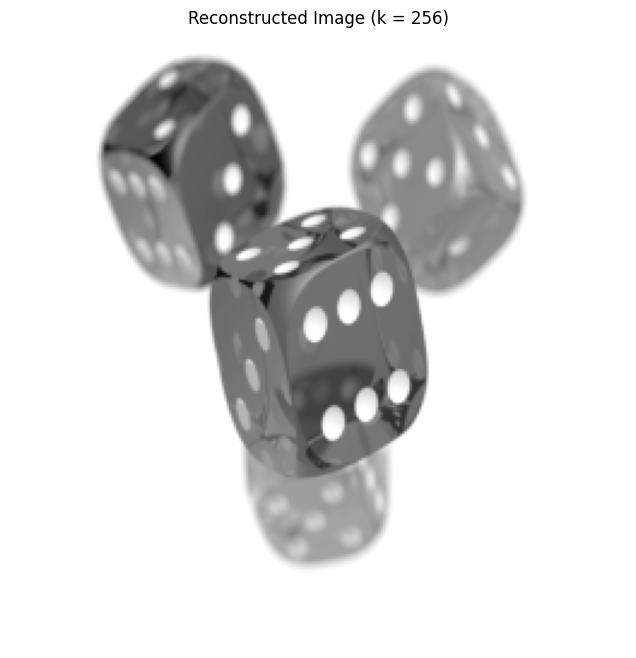

U_k shape: (256, 256)
Σ_k shape: (256, 256)
V_k shape: (256, 256)
Approximation Formula: U_k * Σ_k * V_k^T


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize

# 画像の読み込みと前処理
url = 'https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png'
image = io.imread(url)
image = resize(image, (256, 256), anti_aliasing=True)  # サイズを256x256にリサイズ

# RGBA -> RGB に変換 (アルファチャンネルの削除)
if image.shape[2] == 4:
    image = color.rgba2rgb(image)

# グレースケール化
gray_image = color.rgb2gray(image)

# **特異値分解の数式**
# 行列 X を分解する: X = U Σ V^T
U, S, Vt = np.linalg.svd(gray_image, full_matrices=False)

# 各ステップの説明と結果表示
def visualize_svd_process(k):
    """
    k 個の特異値を使用した再構成画像を表示しながら数式を説明する
    """
    print(f"\n--- 使用する特異値の数 k = {k} ---")

    # 1. 元の特異値 Σ をトリム (上位 k 個だけを保持)
    S_k = np.zeros_like(S)
    S_k[:k] = S[:k]  # 上位 k 個の特異値を保持
    Σ_k = np.diag(S_k)  # 対角行列形式の Σ_k を作成

    # 数式 (再構成用)
    # 再構成: X_k = U[:, :k] @ Σ_k[:k, :k] @ Vt[:k, :]
    # 対応する数式: X_k ≈ U_k * Σ_k * V_k^T
    U_k = U[:, :k]
    V_k = Vt[:k, :]
    X_k = np.dot(U_k, np.dot(Σ_k[:k, :k], V_k))  # 数式通り計算

    # 結果のプロット
    plt.figure(figsize=(8, 8))
    plt.imshow(X_k, cmap='gray')
    plt.title(f"Reconstructed Image (k = {k})")
    plt.axis('off')
    plt.show()

    # 各行列の形状を出力して理解を補助
    print(f"U_k shape: {U_k.shape}")
    print(f"Σ_k shape: {Σ_k[:k, :k].shape}")
    print(f"V_k shape: {V_k.shape}")
    print(f"Approximation Formula: U_k * Σ_k * V_k^T")

# 特異値の数 k を変えて試す
for k in [5, 20, 50, 100, 256]:  # 小さい k から元のサイズまで
    visualize_svd_process(k)

Model 1's Loss: 0.2231
Model 2's Loss: 1.2040


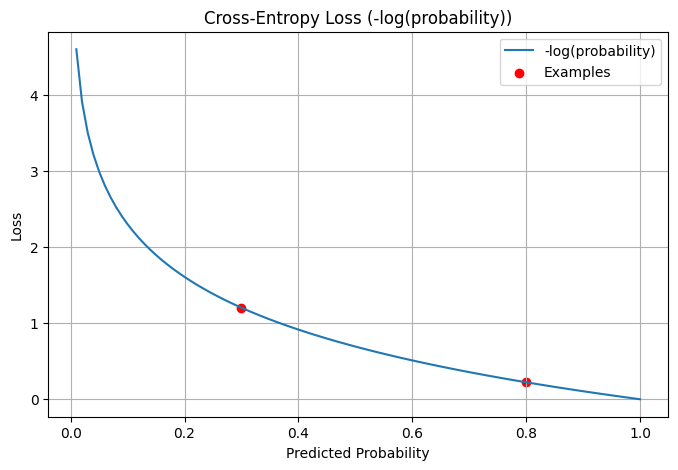

In [ ]:
import numpy as np

# 正解ラベル (ワンホットエンコーディング)
# クラス「犬」が正解
true_labels = np.array([0, 1, 0])  # 猫:0, 犬:1, 鳥:0

# モデルの予測分布
# モデル1の予測（正しい方向）
predictions_1 = np.array([0.1, 0.8, 0.1])  # 猫:10%, 犬:80%, 鳥:10%
# モデル2の予測（間違った方向）
predictions_2 = np.array([0.4, 0.3, 0.3])  # 猫:40%, 犬:30%, 鳥:30%

# 交差エントロピー損失を計算する関数
def cross_entropy_loss(true_labels, predictions):
    """
    true_labels: 正解ラベル (ワンホット)
    predictions: モデルの予測確率分布
    """
    # 損失計算 (logは自然対数)
    loss = -np.sum(true_labels * np.log(predictions))
    return loss

# モデル1の損失
loss_1 = cross_entropy_loss(true_labels, predictions_1)
print(f"Model 1's Loss: {loss_1:.4f}")

# モデル2の損失
loss_2 = cross_entropy_loss(true_labels, predictions_2)
print(f"Model 2's Loss: {loss_2:.4f}")

# グラフで視覚化
import matplotlib.pyplot as plt

# 確率の範囲 (0.01〜1)
probs = np.linspace(0.01, 1, 100)
losses = -np.log(probs)

plt.figure(figsize=(8, 5))
plt.plot(probs, losses, label="-log(probability)")
plt.scatter([0.8, 0.3], [-np.log(0.8), -np.log(0.3)], color='red', label="Examples")
plt.title("Cross-Entropy Loss (-log(probability))")
plt.xlabel("Predicted Probability")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()